In [10]:
import re
import pandas as pd
import numpy as np

import pprint as pp
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

import xgboost as xgb
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score

# uncomment and run it first!

# import nltk
# nltk.download('wordnet')
# nltk.download('stopwords')

%pylab inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

Populating the interactive namespace from numpy and matplotlib


In [38]:
# %%writefile nlp_process_data.py

def build_pipe(vect, model, stopwords=None, ngram_range=(1,1), min_df=3):
    return Pipeline([("count", vect(stop_words=stopwords, ngram_range=ngram_range, 
                                    min_df=min_df)),
                     ("model", model())])

def text_cleaning(data, func):
    # This func applies given func to every word
    # Regex capture only rus, lat words
    # Returns Series -> Series[row] = text:str
    series = data.copy()
    for i in range(data.shape[0]):
        text = series.iloc[i]
        pattern = re.compile(r"(?u)[a-zа-я]+")
        word_list = re.findall(pattern, text.lower())
        series.iloc[i] = " ".join([func(w) for w in word_list if len(w) > 2])
    return series

def handle_rawdata(X_train, X_test, func=None):
    # Appiles apply_to_str, text_cleaning functions to given Series
    pr_data = list()
    for data in [X_train, X_test]:
        pr_data.append(text_cleaning(data, func))
    return pr_data

def train_test_models(X_train, y_train, cv=3, models_cls=None, vectorizer_cls=None, 
                      random_state=None, min_df=None,stopwords=None, 
                      ngram_range=(1,1), model_names=None, vectorizer_names=None):
    
    worked_models = list()
    mean = list()
    scores = list()
    
    if not models_cls or not vectorizer_names:
        models_cls = [LogisticRegression,
                      RandomForestClassifier,
                      LinearSVC,
                      SGDClassifier]
        model_names = ["LogReg", "RF Clas.", "LinearSVC", "SGD Clas."]
        
    if not vectorizer_cls or not model_names:
        vectorizer_cls = [TfidfVectorizer, CountVectorizer]
        vectorizer_names = ["TfidfVec", "CntVec"]
       
    vectorizer_names = iter(vectorizer_names)
    for vectorizer in vectorizer_cls:
        vector_name = next(vectorizer_names)
        model_names = iter(model_names)
        model_score = list()
        for model in models_cls:
            pipe = build_pipe(vectorizer, model, stopwords=stopwords,
                              ngram_range=ngram_range, min_df=min_df)
            score = cross_val_score(pipe, X_train, y_train, scoring='accuracy',cv=cv)
        
            mean.append(np.mean(score))
            model_score.append(score)
            worked_models.append(next(model_names) + vector_name)
        scores.append(model_score)
    return worked_models, mean, scores

Overwriting nlp_process_data.py


In [3]:
path = "/media/winter/vm/github/kaggle/Product_Sentiment/"
kagle_data = open(path+"test.csv", "r").readlines()

kagle_data = " ".join(kagle_data).split("</review>")[:-1]
X_kaggle_raw = pd.Series([text.replace('<review>', "").replace("\n", "") for text in kagle_data])

stop_words = stopwords.words('russian')

data = pd.read_csv("phone_reviews_final.csv", sep=',', header=0, names=['index','mark','rev'])
data.drop('index', axis=1, inplace=True)


print(data.shape)
print(data['mark'].value_counts())

(10709, 2)
1.0    8458
0.0    2251
Name: mark, dtype: int64


Because of unevenness of frequencies 1:8458 and 0:2251  
I'm going to use class_weights to balance weights of 0 marked revies by 3 

In [ ]:
# Override
def handle_rawdata(X_train, X_test, X_kaggle, func):
    pr_data = list()
    for data in [X_train, X_test, X_kaggle]:
        pr_data.append(text_cleaning(data, func))
    return pr_data
"""
WordNetLemmatizer().lemmatize
SnowballStemmer('russian').stem
PorterStemmer().stem
"""
X_train, X_test = train_test_split(data['rev'].copy(), random_state=42)
y_train, y_test = train_test_split(data['mark'].copy(), random_state=42)

X_train, X_test, X_kaggle = handle_rawdata(X_train, X_test, X_kaggle_raw.copy(), SnowballStemmer('russian').stem)
X_full = X_train.append(X_test)
y_full = data['mark']

In [32]:
multi_model = train_test_models(data['rev'],data['mark'], min_df=3, ngram_range=(1,3), stopwords=stop_words, cv=5)
multi_model

(['LogReg TfidfVec',
  'RF Clas. TfidfVec',
  'LinearSVC TfidfVec',
  'SGD Clas. TfidfVec',
  'LogReg CntVec',
  'RF Clas. CntVec',
  'LinearSVC CntVec',
  'SGD Clas. CntVec'],
 [0.7900835005281228,
  0.7814896903748997,
  0.7838242624463103,
  0.7908291575761464,
  0.7648670469191783,
  0.7840112663289209,
  0.7389977412246866,
  0.7406822058813909],
 [[array([0.78814746, 0.78898226, 0.79084967, 0.78981784, 0.79262027]),
   array([0.78208119, 0.79178338, 0.79691877, 0.77814106, 0.75852405]),
   array([0.77928138, 0.79691877, 0.80578898, 0.7725362 , 0.76459598]),
   array([0.78721419, 0.79785247, 0.8015873 , 0.78468006, 0.78281177])],
  [array([0.76061596, 0.77497666, 0.80205415, 0.7463802 , 0.74030827]),
   array([0.78908073, 0.7875817 , 0.79365079, 0.77440448, 0.77533863]),
   array([0.7480168 , 0.74976657, 0.78338002, 0.71742177, 0.69640355]),
   array([0.72795147, 0.76143791, 0.77964519, 0.72349369, 0.71088277])]])

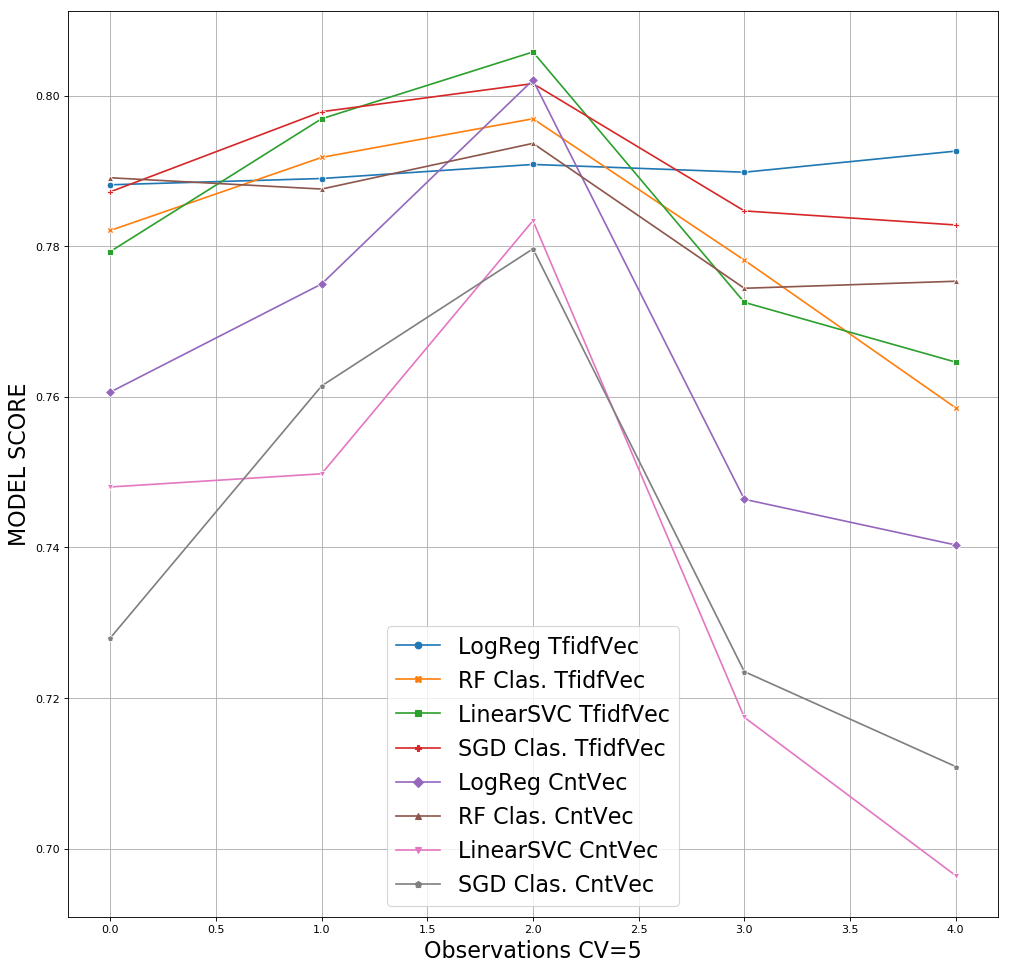

In [33]:
names_ =  multi_model[0]
scores_ = [i for j in multi_model[2] for i in j]
plt.figure(dpi=80, figsize=(15,15))
sns.lineplot(data= pd.DataFrame(dict(zip(names_,scores_))),dashes=False,markers=True,
             size=np.array([2 for i in range(0,8)]))
plt.xlabel("Observations CV=5", fontsize=20)
plt.ylabel("MODEL SCORE", fontsize=20)
plt.grid(True)
plt.legend(fontsize=20)

In [ ]:
# I gave x3 to 0 class weight to balance classes
model = LogisticRegression(penalty='l2', C=0.1,
                           class_weight={0:1, 1:1}, solver='lbfgs', n_jobs=-1)
vectorizer = TfidfVectorizer(ngram_range=(1,3), min_df=3)

X_train_, X_test_, X_kaggle_ = X_train.copy(), X_test.copy(), X_kaggle.copy()

vectorizer.fit(X_train_)
X_train_ = vectorizer.transform(X_train_)
model.fit(X_train_, y_train)

X_test__ = vectorizer.transform(X_test_)
model_pred = model.predict(X_test__)

model_acc = accuracy_score(y_test, model_pred)
print("model score: ", model_acc)
print("vocab capacity:",len(vectorizer.vocabulary_))

In [24]:
# Let see most valuable words in the model
coef = model.coef_.tolist()[0]
most_valuable_features = [coef.index(i) for i in sorted(coef)[:100]]
features = np.array(vectorizer.get_feature_names())

mvf = features[most_valuable_features]
mvf_cnt = [vectorizer.vocabulary_.get(i) for i in mvf]

most_valuable_words = sorted(list(zip(mvf, mvf_cnt)), key=lambda tup: tup[1])
mvf

array(['постоянно', 'телефон', 'невозможно', 'динамик', 'память',
       'аккумулятор', 'тормозит', 'месяц', 'плохая', 'пол', 'ремонт',
       'начал', 'звонок', 'слабый', 'ужасно', 'покупать', 'зависает',
       'звонит', 'второй', 'внешний', 'тихий', 'день', 'рублей', 'меню',
       'год', 'плохо', 'полное', 'приходится', 'позвонить', 'сказали',
       'глючит', 'плохая камера', 'перестал', 'нокиа', 'крупные',
       'пол года', 'магазин', 'вообще', 'гарантии', 'виснет', 'смс',
       'покупки', 'нормальный', 'сильно', 'кнопки', 'слабая', 'большие',
       'проблема', 'никому', 'nokia', 'телефона', 'сервис',
       'перезагрузка', 'отключается', 'года', 'глючить', 'другого',
       'показывает', 'дней', 'сдать', 'сдал', 'нормальный телефон',
       'вызова', 'мало', 'обратно', 'ронял', 'никакая', 'завышена цена',
       'никак', 'сломался', 'греется', 'реагирует', 'завышена', 'плохой',
       'покупайте', 'периодически', 'звонилка', 'ужасный',
       'ужасный телефон', 'кусок', 'каме

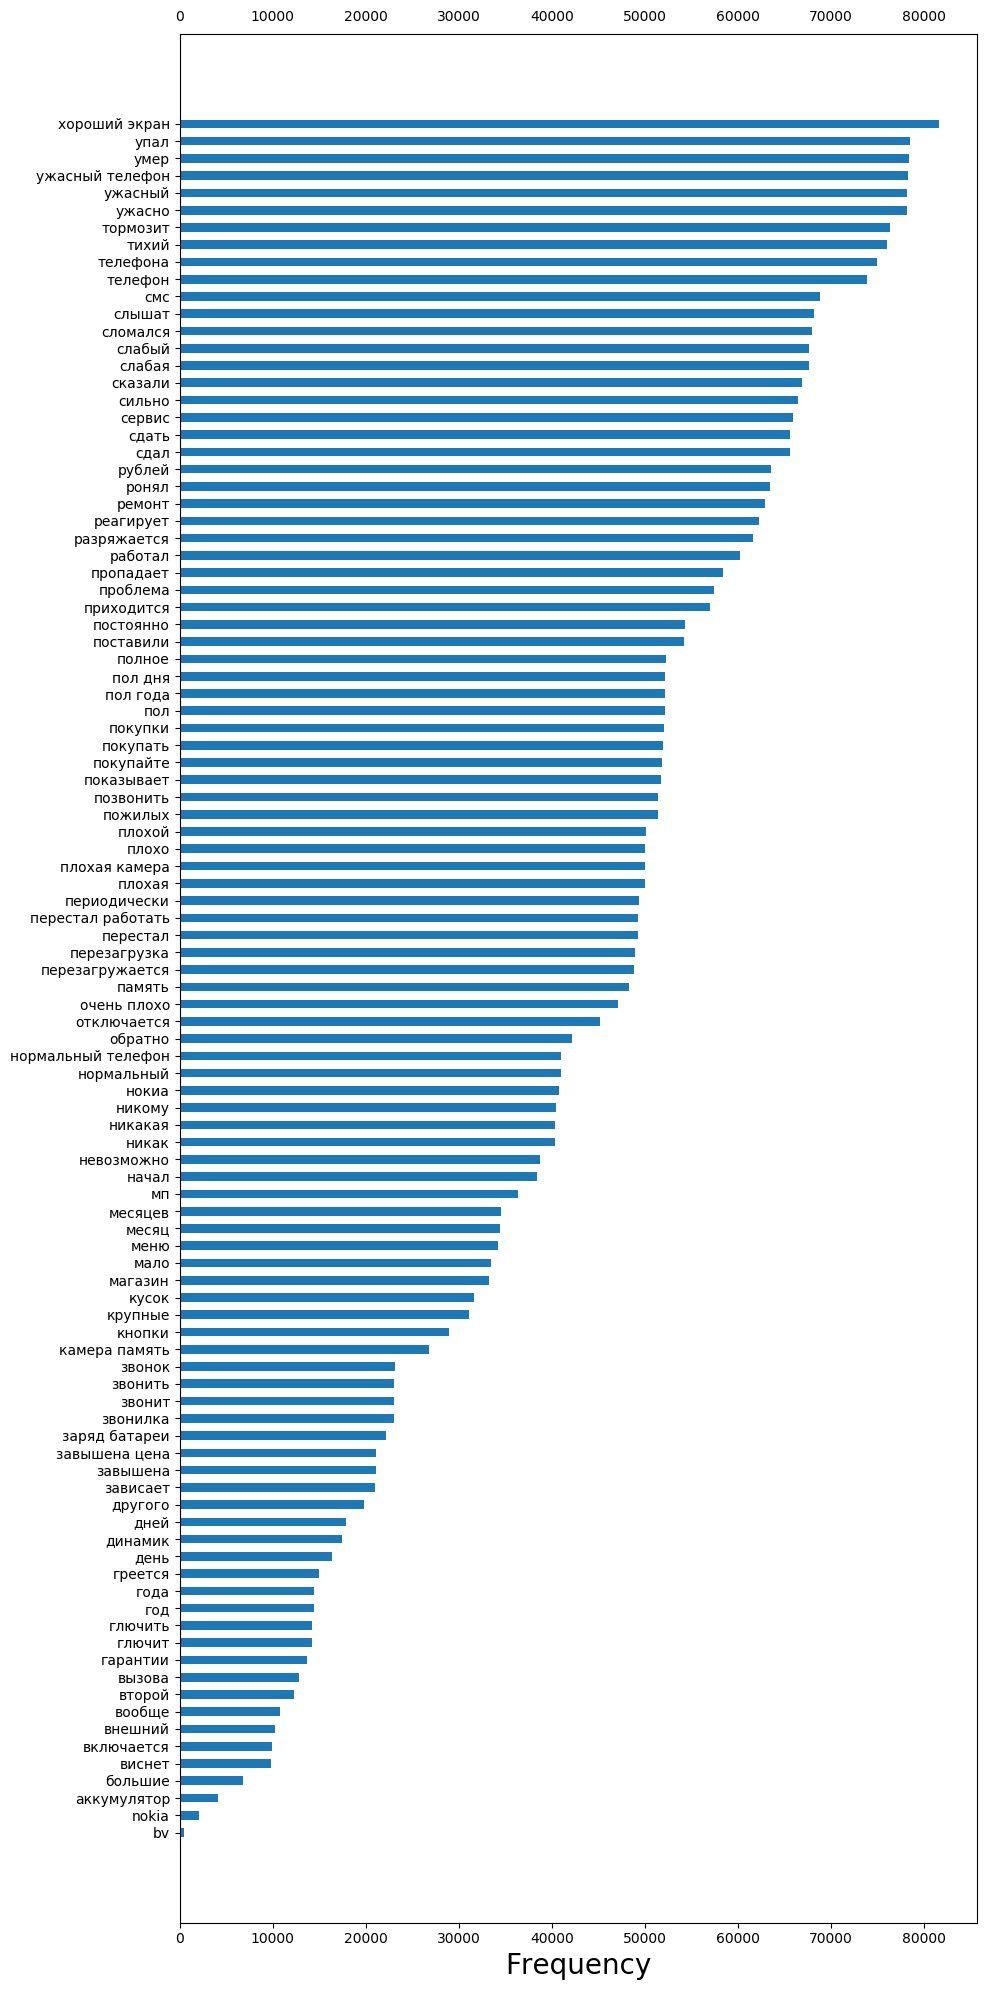

In [25]:
_x,_y = zip(*most_valuable_words)

plt.figure(figsize=(10,20), dpi=100)
plt.barh(_x, _y, height=0.5)
plt.xlabel('Frequency', fontsize=20)
plt.tick_params(labelbottom='on',labeltop='on')
plt.tight_layout()
plt.show()

In [12]:
sub_predict = ['pos' if i else 'neg' for i in model.predict(vectorizer.transform(X_kaggle_))]
submit = pd.DataFrame({'y':sub_predict})
submit.index.name='id'
submit.to_csv("submission.csv", sep=',')

In [13]:
submit['y'].value_counts()

pos    56
neg    44
Name: y, dtype: int64

In [13]:
# # Cross validation score
# model = LogisticRegression(penalty='l2', C=0.1,
#                            class_weight={0:3, 1:1}, solver='liblinear', n_jobs=3)
# vectorizer = CountVectorizer(ngram_range=(1,3), min_df=3)

# pipe = Pipeline([("vectorizer", vectorizer), ("model", model)])


# cross_acc = cross_val_score(pipe, full_fp, full_mark, scoring='accuracy', cv=5)
# print("cross score: ", cross_acc,"mean: ", np.mean(cross_acc))

cross score:  [0.74475035 0.77684407 0.79551821 0.72909855 0.70667912] mean:  0.7505780604410838


In [15]:
# grid_params = {"C":np.logspace(-4, 4, 20),
#               "solver":["lbfgs", "saga", "sag", "liblinear"],
#               "class_weight":[{0:1.5, 1:1}, {0:2, 1:1}, {0:1, 1:1}],
#               "intercept_scaling":[1,2,4, 0.5]}
# grid_model = GridSearchCV(cv=5, estimator=LogisticRegression(), 
#                           param_grid=grid_params, scoring='accuracy', n_jobs=3)

# grid_model.fit(X_train__, y_train)
# grid_pred = grid_model.predict(X_test__)

In [ ]:
# grid_model.best_score_

In [ ]:
# grid_model.best_estimator_